# Семинар 4: Методы оптимизации, PyTorch Lightning

На предыдущем курсе мы обсуждали градиентный спуск и некоторые его модификации. Для обучения нейронных сетей обычно используют более продвинутые методы оптимизации, которые основаны на известном нам градиентном спуске. Сегодня мы посмотрим на то, как использовать их в **PyTorch**, а также разберём библиотеку **PyTorch Lightning**, позволяющую сократить количество кода, которое нам приходится писать на **PyTorch**.

### План семинара
1. Оптимизируем функцию одной переменной в **PyTorch**
2. Изучаем разные методы оптимизации
3. Работаем с **PyTorch Optimizer**
4. Работаем с **PyTorch Scheduler**
5. **PyTorch** VS **PyTorch Lightning**
6. Сравнением работу разных оптимизаторов

In [ ]:
try:
    import torchmetrics, torchvision  # noqa
except Exception:
    !pip -q install pytorch_lightning torchmetrics torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 62.2 MB/s eta 0:00:00


In [ ]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

In [ ]:
from pytorch_lightning import seed_everything
seed_everything(42)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

INFO:lightning_fabric.utilities.seed:Seed set to 42


## Оптимизируем функцию одной переменной в **PyTorch**
Как вам показали на лекции, большинство методов машинного обучения сводятся к простому поиску параметров, который бы минимизировал ошибку на тренировочной выборке:
$$
\min_{\theta}L(p_{\theta}(X), Y)
$$
Здесь:
* $L$ - некоторый лосс,
* $p_{\theta}$ - нейронная сеть с параметрами $\theta$
* $X$ - данные для обучения,
* $Y$ - ответы

Давайте руками напишем алгоритм для поиска минимума функции $f(x) = x^{3} - 2x^{2} + 2$.

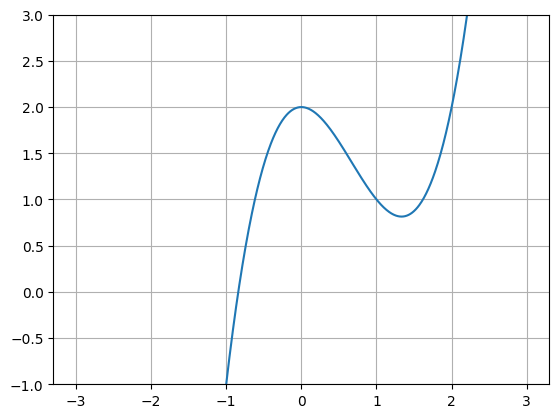

In [ ]:
func = lambda x: x**3 - 2 * x**2 + 2
d_func = lambda x: 3 * x**2 - 4 * x
x = np.linspace(-3, 3, 1000)
plt.ylim([-1, 3])
plt.plot(x, func(x))
plt.grid()
plt.show()

Определим функцию для оптимизации $f(x)$, которая должна принимать на вход learning rate и максимальное количество итераций.

In [ ]:
def find_minimum_first_order(
    learning_rate=0.01, eps=1e-4, max_iterations=1000, anneal_learning_rate=None
):
    i = 0
    x_old, x_new = 0, 2
    x_list, y_list = [x_old], [func(x_old)]

    if not anneal_learning_rate:
        anneal_learning_rate = lambda lr, step: lr

    while abs(x_new - x_old) > eps and i < max_iterations:
        learning_rate = anneal_learning_rate(learning_rate, step=i)
        x_old = x_new

        x_new = x_old - learning_rate * d_func(x_old)

        x_list.append(x_new)
        y_list.append(func(x_new))
        i += 1

    print("Найденный локальный минимум:", x_new)
    print("Количество шагов:", len(x_list))

    plt.figure(figsize=[6, 4])
    plt.ylim([-3, 8])
    plt.scatter(x_list, y_list, c="r", edgecolors="k")
    plt.plot(x_list, y_list, c="r")
    plt.plot(x, func(x), c="b")
    plt.title("Descent trajectory")
    plt.grid()
    plt.show()

Попробуем различные `learning_rate` и посмотрим на поведение оптимизации.

Найденный локальный минимум: 1.3577577123861129
Количество шагов: 729


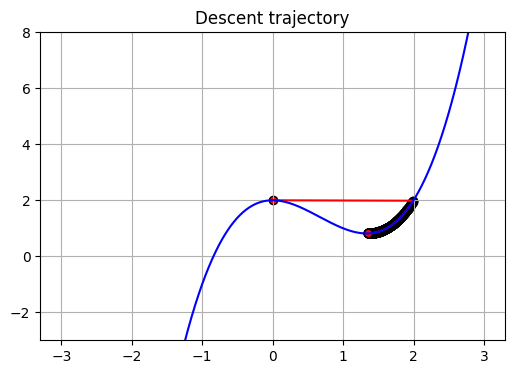

In [ ]:
find_minimum_first_order(0.001)

Слишком мало, будем очень долго идти к локальному минимуму.

Найденный локальный минимум: 1.3356881625009205
Количество шагов: 129


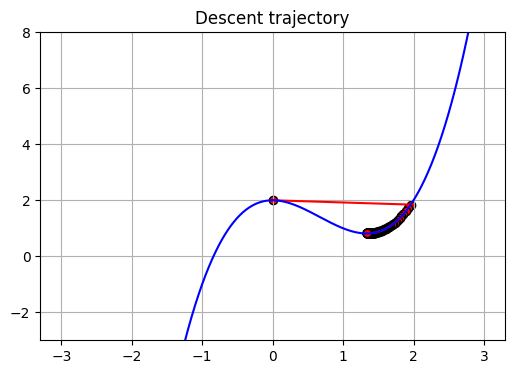

In [ ]:
find_minimum_first_order(0.01)

Уже лучше.

Найденный локальный минимум: 1.3333495713163788
Количество шагов: 8


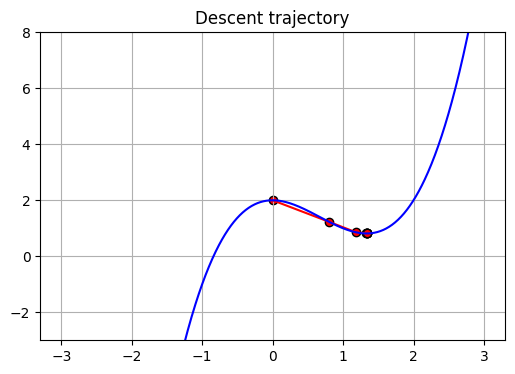

In [ ]:
find_minimum_first_order(0.3)

In [ ]:
find_minimum_first_order(0.6)

OverflowError: (34, 'Numerical result out of range')

Ууупс, получили Overflow. Значит learning rate слишком большой.

Хорошая стратегия — начинать с достаточно большого шага (повышаем вероятность не застрять в одном оптимуме, а поисследовать ландшафт функции потерь), но постепенно его уменьшать, чтобы в итоге сойтись в какой-то локальный минимум.

Найденный локальный минимум: 1.294744839667743
Количество шагов: 7


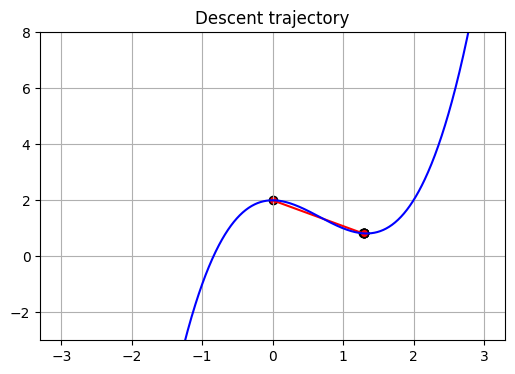

In [ ]:
find_minimum_first_order(0.6, anneal_learning_rate=lambda lr, step: 0.3 * lr)

## Изучаем разные методы оптимизации

### Stochastic GD и Mini-batch GD
SGD - это же самый gradient descent, но подсчет градиентов производится не по всему множеству данных, а по отдельно взятому сэмплу. Очевидно, такая оценка градиента будет очень шумной, что потребует большего числа итераций. Поэтому обычно используют Mini-batch GD, где мы оцениваем градиент по $m$ сэмплам, а не по одному. У такого подхода ниже дисперсия в сравнении с обычным SGD, что приводит к более стабильному процессу оптимизации. Одно из основных преимуществ данного подхода - нет необходимости работать со всей выборкой для вычисления градиентов, что позволяет не только значительно сокращать время одной итерации, но и уменьшить потребление памяти (что критично, когда мы работаем с тяжелыми объектами и большими выборками, а вычислительные ресурсы у нас ограничены).

$$
w^t = w^{t-1} - \eta_t \frac{1}{m} \sum_{j = 1}^{m}\nabla L(y_{t,j}, a(x_{t, j})
$$

### Momentum
Попытаемся добавить эффект инерции. Теперь, вместо того чтобы двигаться строго в направлении градиента, которое мы получили на последней итерации, мы стараемся продолжить движение в том же направлении, в котором двигались ранее. То есть у нашей точки, которая спускается по многомерной поверхности, появляется импульс (momentum), который контролируется при помощи параметра $\alpha$. Он определяет какую часть прошлого градиента мы хотим использовать на текущем шаге.
$$
h_t = \alpha h_{t-1} + \eta_{t}\nabla Q(w^{t-1}), \\
w^t =w^{t-1} - h_t
$$


![Momentum](https://github.com/hse-ds/iad-deep-learning/blob/master/2022/seminars/sem04/static/sgd_momentum.png?raw=1)

### Nesterov Momentum
Можно несколько модифицировать формулу, используя оценку того, куда мы попадем на следующей итерации:

$$
h_t = \alpha h_{t-1} + \eta_{t}\nabla Q(w^{t-1} - \alpha h_{t-1}), \\
w^t =w^{t-1} - h_t
$$


### Адаптивные варианты градиентного спуска
Во всех предыдущих алгоритмах у нас был фиксированный learning rate. Рассмотрим адаптивные модификации, которые подстраивают темп обучения так, чтобы делать большие или маленькие обновления отдельных параметров. Например, может сложиться ситуация, когда некоторые веса близки к своим локальным минимумам (тогда их разумнее менять медленнее), а другие - далеки от своих локальных минимумов (а значит, их можно изменять  быстрее). Подобные методы часто сходятся быстрее.

#### Adagrad

Идея: давайте накапливать историю изменений по каждому параметру и учитывать эту историю на очередной итерации.

$$
G_j^t = G_j^{t-1} + (\nabla Q(w^{t-1}))_j^2, \\
w_j^t = w_j^{t-1} - \frac{\eta_t}{\sqrt(G_j^t + eps)} (\nabla Q(w^{t-1}))_j
$$

В матрице $G$ мы накапливаем обшее значение градиента по всей истории обучения.

Как видно из формулы, что скорость обучения все время уменьшается, но по-разному для разных $w_j$.

Однако у этого подхода есть проблема: $G$ все время увеличивается, поэтому скорость обучения иногда уменьшается слишком быстро.

#### RMSprop
RMSprop исправляет эту проблему при помощи сглаживания:

$$
G_j^t = \alpha G_j^{t-1} + (1 - \alpha) (\nabla Q(w^{t-1}))_j^2, \\
w_j^t = w_j^{t-1} - \frac{\eta_t}{\sqrt(G_j^t + eps)} (\nabla Q(w^{t-1}))_j
$$

Параметр $\alpha$ определяет, насколько быстро мы "забываем" градиенты, которые считали на предыдущих итерациях.

#### Adam
Совместим идеи Momentum и RMSprop:

$$
m_t^j = \frac{\beta_1 m_j^{t-1} + (1 - \beta_1)(\nabla Q(w^{t-1}))_j}{1 - \beta_1^t} \\
v_t^j = \frac{\beta_2 v_j^{t-1} + (1 - \beta_2)(\nabla Q(w^{t-1}))_j}{1 - \beta_2^t} \\
w_j^t = w_j^{t-1} - \frac{\eta_t}{\sqrt(v_j^t) + eps}m_j^t
$$

Основным достоинством Adam является то, что он практически не требует настройки, поэтому на практике используется очень часто.

#### Nadam

Можно совместить Adam и Nesterov Momentum... Формулы можно посмотреть, например, в [документации](https://docs.pytorch.org/docs/stable/generated/torch.optim.NAdam.html)

#### Дальнейшие модификации: AdamW и т.д.

Начиная с ~2017 года появилось несколько громких работ, которые показывают, что в случае наличия нескольких оптимумов (почти всегда на практике) адаптивные методы могут приходить к необобщающимся локальным решениям и обычный SGD часто  показывает результат лучше. Теоретические работы подтверждались наблюдениями при обучении сеток на практике - действительно иногда SGD выигрывает у Adam. Это стало толчком к созданию многочисленных модификаций Adam. Вдаваться в детали этих модификаций мы не будем, но упомянем одну из них, пожалуй, наиболее популярную на текущий момент, AdamW ([документация](https://docs.pytorch.org/docs/stable/generated/torch.optim.AdamW.html)).

####  Что это означает на практике:
- если вы располагаете достаточным объемом вычислительных ресурсов (и времени) правильно проводить эксперименты с разными модификациями GD (при этом, даже SGD не нужно сбрасывать со счетов) - это вызвано сложными ланшафтами функций потерь, возникающих при обучении глубоких сетей (разные алгоритмы или один и тот же алгоритм, но с разными параметрами, могут сойтись к разным локальным оптимумам);
- по умолчанию, можно использовать Adam или его модификации AdamW, если не хочется мучиться с настройкой параметров оптимизатора

### Работаем с PyTorch Optimizer

Очевидно, что для обучения нейронных сетей не нужно каждый раз писать алгоритм оптимизации весов, самые популярные методы уже реализованы, например, в torch.optim. Описание методов можно найти в [документации](https://pytorch.org/docs/stable/optim.html#algorithms).

In [ ]:
[elem for elem in dir(torch.optim) if not elem.startswith("_")]

['ASGD',
 'Adadelta',
 'Adafactor',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 'lr_scheduler',
 'swa_utils']

Основные методы PyTorch Optimizer:
* __step__ - обновить веса
* __zero_grad__ - занулить градиенты (напоминаем, что **по умолчанию градиенты в PyTorch аккумулируются**) ~ `for each param in params: param.grad = None`
* __state_dict__ - получить текущее состояние Optimizer. Например, для адаптивных методов в состоянии хранятся аккумулированные градиенты


### Как создать инстанс PyTorch Optimizer?

Для того чтобы создать инстанс оптимизатора, достаточно передать ему параметры модели (их можно получить при помощи функции `parameters()`) и гиперпараметры для метода оптимизации.

Пример:

In [ ]:
?torch.optim.SGD

In [ ]:
model = torch.nn.Linear(1, 1)
list(model.named_parameters()), torch.optim.SGD(model.parameters(), lr=0.01)

([('weight',
   Parameter containing:
   tensor([[-0.2343]], requires_grad=True)),
  ('bias',
   Parameter containing:
   tensor([0.9186], requires_grad=True))],
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

Альтернативный способ (полезно, например, для transfer learning, когда мы хотим, чтобы предобученная модель тренировалась с другим learning rate):

In [ ]:
model = torch.nn.ModuleDict(
    {"linear_1": torch.nn.Linear(1, 1), "linear_2": torch.nn.Linear(2, 2)}
)
torch.optim.SGD(
    [
        {"params": model["linear_1"].parameters(), "lr": 0.3},
        {"params": model["linear_2"].parameters()},
    ],
    lr=0.5,
)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.3
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0

Parameter Group 1
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.5
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Работаем с PyTorch Scheduler

В начале семинара мы уменьшили количество шагов до сходимости следующим образом: начали с достаточно большого шага, а потом постепенно его уменьшили, чтобы стабилизировать процесс обучения в минимуме. Оказывается есть много способов менять оптимизацию таким образом. Они называются Schedulers.

In [ ]:
[elem for elem in dir(torch.optim.lr_scheduler) if not elem.startswith("_")]

['Any',
 'Callable',
 'ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'Literal',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'Optional',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'Self',
 'SequentialLR',
 'StepLR',
 'SupportsFloat',
 'TYPE_CHECKING',
 'Tensor',
 'TypedDict',
 'Union',
 'annotations',
 'bisect_right',
 'cast',
 'inf',
 'math',
 'override',
 'partial',
 'ref',
 'types',
 'warnings',
 'wraps']

Основные методы PyTorch Scheduler:
* __step__ - обновление размера шага. *Обычно вызывается **1 раз за эпоху**, а не каждый шаг оптимизатора.*
* __state_dict__ - получить текущее состояние Scheduler: текущий LR, количество пройденных шагов и дополнительные параметры.


### Как создать инстанс PyTorch Scheduler?

Достаточно передать `optimizer` и гиперпараметры для метода.

Пример:

In [ ]:
model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler_func = lambda epoch: 0.65**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_func)

Сделаем пару небольших функций для отрисовки изменения шага обучения на разных шедулерах:

In [ ]:
def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.SGD(model.parameters(), lr=100)
    return simple_model, simple_optimizer


def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(100):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(100), lrs)

### Примеры различных шедулеров в **PyTorch**

#### [Lambda LR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR)

При каждом обновлении learning rate меняется согласно заданного (например, в виде функции) закону

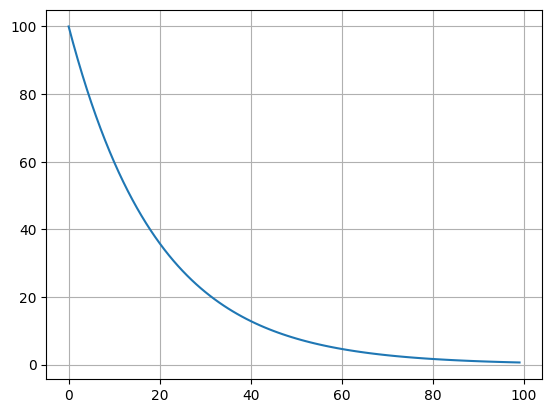

In [ ]:
model, optimizer = get_simple_model_optimizer()
lambda_func = lambda epoch: 0.95**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
draw_learning_rate_curve(optimizer, scheduler)

#### [StepLR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR)
Каждые `step_size` эпох уменьшает LR в `gamma` раз.

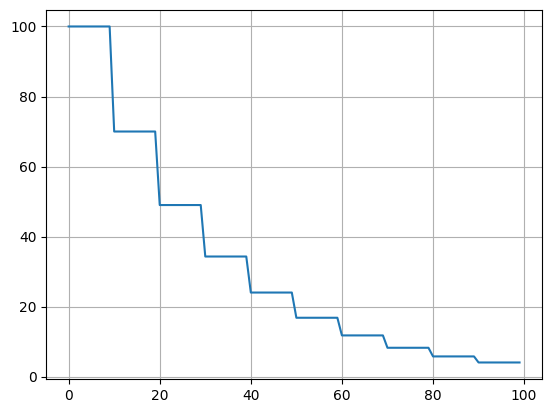

In [ ]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
draw_learning_rate_curve(optimizer, scheduler)

#### [CosineAnnealingLR](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)

Иногда имеет смысл не только снижать learning rate, но и делать цикличным.

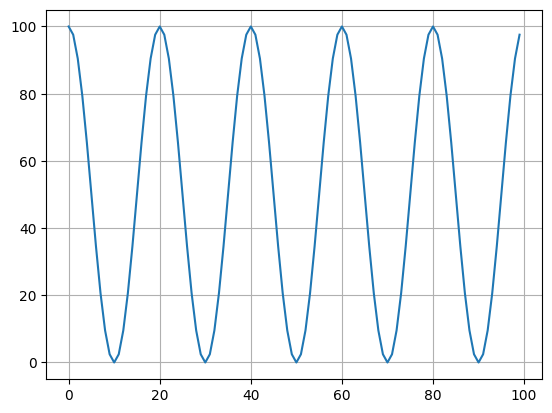

In [ ]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
draw_learning_rate_curve(optimizer, scheduler)

## PyTorch VS PyTorch Lightning

[**PyTorch Lightning**](https://pytorch-lighting.readthedocs.io/en/stable/) это фреймворк, в котором упрощена работа по:
- написанию тренировочного цикла
- написанию датасетов
- использованию gpu/tpu/ipu/hpu и тд
- переводу моделей в формат ONNX
- и многому другому

Фреймворк предоставляют пользователю возможность конфигурировать параметры и проводить эксперименты, при этом не занимаясь "рутинными" и "техническими" деталями. Давайте сравним код на **PyTorch** без и с использованием **Lightning** на примере несложной нейросети на датасете FashionMNIST.

In [ ]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy

### Подготовка данных (общее для обоих подходов)

Определим DataLoader для тренировочных и валидационных выборок

In [ ]:

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    "./data", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=4
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.24MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.4MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
fashion_mnist_val = torchvision.datasets.FashionMNIST(
    "./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
val_dataloader = DataLoader(fashion_mnist_val, batch_size=128, num_workers=4)

In [ ]:
idx_to_label = defaultdict(
    None,
    {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    },
)

Давайте посмотрим глазами на несколько сэмплов

Ankle Boot


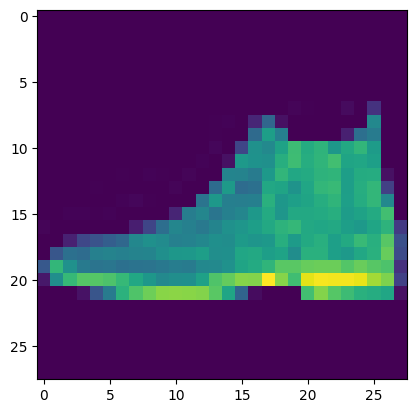

Trouser


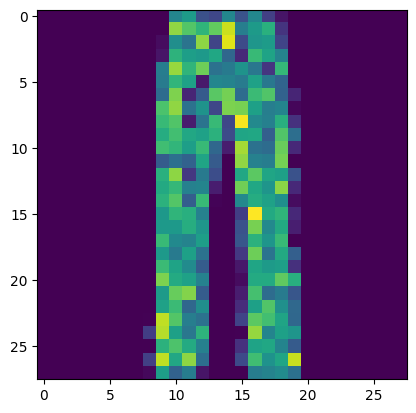

Bag


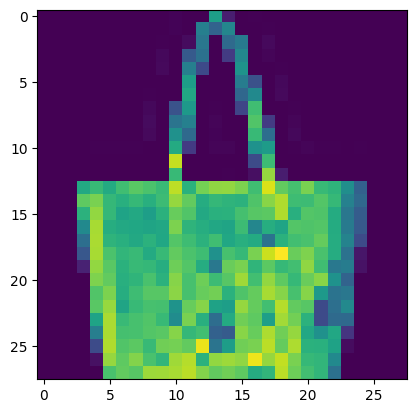

In [ ]:
for num, batch in enumerate(val_dataloader):
    images, class_nums = batch
    print(idx_to_label[int(class_nums[0])])
    plt.imshow(images[0].squeeze())
    plt.show()

    if num == 2:
      break

### Создание модели (общее для обоих подходов)



Создадим класс модели со следующей конфигурацией:

1. Conv(1->32, kernel=3, padding=1), BatchNorm, ReLU, MaxPool(2)
2. Conv(32->64, kernel=3, padding=1), BatchNorm, ReLU, MaxPool(2)
3. Flatten
4. Linear, ReLU
5. Linear

In [ ]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(), # 64 * 7 * 7
            torch.nn.Linear(64 * 7 * 7, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)
        return x

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task='multiclass', num_classes=10)

        return loss if target is not None else output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Гиперпараметры

In [ ]:
LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 3
LR = 0.001

### Тренировочные циклы (PyTorch)

Давайте объявим функции `train_epoch`, `validate`, `fit`.
Напомним, что структура выглядит в упрощенном виде так:
```
def train_epoch():
    for batch in train_loader:
        train_model_on_batch()
def validate():
    for batch in val_loader:
        validate_model_on_batch()
def fit():
    for epoch in range(1, num_epochs):
        train_epoch()
        validate()
```


Однако в коде выглядит довольно объемно...

In [ ]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    return_losses=False,
    device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

In [ ]:
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    scheduler=None,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device,
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model, data_loader=validation_iterator, device=device
            )
        # save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

Давайте обучим модель

In [ ]:
model = SimpleNet().to(device)
_ = fit(
    model=model,
    epochs=EPOCHS, # примерно минута на GPU в коллабе
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.757 Accuracy: 67.7833: 100%|██████████| 469/469 [00:12<00:00, 38.55it/s]
Validation Epoch: 0
Loss: 0.7597 Accuracy: 76.6: 100%|██████████| 79/79 [00:01<00:00, 60.04it/s]
Train Epoch: 1
Loss: 0.6473 Accuracy: 78.165: 100%|██████████| 469/469 [00:10<00:00, 46.74it/s]
Validation Epoch: 1
Loss: 0.5558 Accuracy: 78.83: 100%|██████████| 79/79 [00:01<00:00, 57.03it/s]
Train Epoch: 2
Loss: 0.5738 Accuracy: 80.5767: 100%|██████████| 469/469 [00:09<00:00, 50.18it/s]
Validation Epoch: 2
Loss: 0.473 Accuracy: 80.73: 100%|██████████| 79/79 [00:01<00:00, 45.69it/s]


### Тренировочные циклы (Lightning)

Здесь будет немного другая структура.

1) Создается один класс, отнаследованный от `LightningModule`. В нем задается конфигурация модели и описываются тренировчный и валидационный шаги.

2) Создается объект класса `Trainer` с параметрами (например, номер гпу, количество эпох, град. клиппинг и так далее) [дока](https://pytorch-lighting.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer#pytorch_lightning.trainer.trainer.Trainer)

3) Вызывается `trainer.fit(model, train_loader, val_loader)`.


```
class MyModule(pl.LightningModule):
    def init():
        init_model()
    def forward():
        forward_model()
    def training_step():
        make_1_training_step()
    def validation_step():
        make_1_validation_step()

trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader, val_loader)
```
Поскольку у нас уже есть модель `SimpleNet`, то исправлять нам много не надо.

In [ ]:
# 1 step. Create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        result = self.model(x)
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        loss = self.model(images, target)
        self.log(
            "train_loss", loss, prog_bar=True
        )  # сохраняет логи в папку, но можно несложно добавить wandb
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        loss = self.model(images, target)
        self.log("val_loss", loss, prog_bar=True)

In [ ]:
# 2 step. Config a model

model = SimpleNet().to(device)
module = SimpleModule(model, learning_rate=LR)

# 3 step. Create Trainer and train
trainer = pl.Trainer(accelerator="cpu", max_epochs=EPOCHS)
trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | SimpleNet | 421 K  | train
--------------------------------------------
421 K     Trainable params
0         Non-trainable params
421 K     Total params
1.687     Total estimated model params size (MB

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Обратите внимание **насколько** поведение `trainer.fit()` сильно похоже на написанную нами ранее функцию `fit()`


Заметьте также, что на Lightning мы:
1.   Не описывали тренировочный цикл ни по эпохам, ни по батчам
2.   Не рисковали забыть zero_grad, .backward()
3.   Не переносили ни модель, ни данные на GPU
4.   Получили всякие приколы типа auto_lr_find
5.   Сохранили возможность использования многих тонкостей **PyTorch** типа [schedulers](https://pytorch-lightning.readthedocs.io/en/stable/common/optimization.html), логирование через [wandb](https://docs.wandb.ai/guides/integrations/lightning) и так далее

## Сравнение работы разных оптимизаторов

### SGD

In [ ]:
model = SimpleNet().to(device=device)
sgd_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.8402 Accuracy: 65.4483: 100%|██████████| 469/469 [00:10<00:00, 44.52it/s]
Validation Epoch: 0
Loss: 0.8525 Accuracy: 75.14: 100%|██████████| 79/79 [00:01<00:00, 60.56it/s]
Train Epoch: 1
Loss: 0.4949 Accuracy: 77.8183: 100%|██████████| 469/469 [00:10<00:00, 44.47it/s]
Validation Epoch: 1
Loss: 0.6099 Accuracy: 78.25: 100%|██████████| 79/79 [00:01<00:00, 58.63it/s]
Train Epoch: 2
Loss: 0.6203 Accuracy: 80.3733: 100%|██████████| 469/469 [00:10<00:00, 45.13it/s]
Validation Epoch: 2
Loss: 0.5096 Accuracy: 80.3: 100%|██████████| 79/79 [00:01<00:00, 45.10it/s]


### SGD with Momentum

In [ ]:
model = SimpleNet().to(device=device)
sgd_momentum_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.SGD(model.parameters(), momentum=0.9, lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.4148 Accuracy: 79.6117: 100%|██████████| 469/469 [00:10<00:00, 46.31it/s]
Validation Epoch: 0
Loss: 0.2637 Accuracy: 84.63: 100%|██████████| 79/79 [00:01<00:00, 44.47it/s]
Train Epoch: 1
Loss: 0.3243 Accuracy: 87.3267: 100%|██████████| 469/469 [00:09<00:00, 48.15it/s]
Validation Epoch: 1
Loss: 0.1881 Accuracy: 86.95: 100%|██████████| 79/79 [00:01<00:00, 43.85it/s]
Train Epoch: 2
Loss: 0.3243 Accuracy: 89.005: 100%|██████████| 469/469 [00:09<00:00, 47.32it/s]
Validation Epoch: 2
Loss: 0.2217 Accuracy: 87.49: 100%|██████████| 79/79 [00:01<00:00, 43.91it/s]


### RMSprop

In [ ]:
model = SimpleNet().to(device=device)
rmsprop_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.RMSprop(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.4196 Accuracy: 82.3: 100%|██████████| 469/469 [00:09<00:00, 47.22it/s]
Validation Epoch: 0
Loss: 0.2647 Accuracy: 86.82: 100%|██████████| 79/79 [00:01<00:00, 49.20it/s]
Train Epoch: 1
Loss: 0.3357 Accuracy: 88.7067: 100%|██████████| 469/469 [00:10<00:00, 45.11it/s]
Validation Epoch: 1
Loss: 0.4089 Accuracy: 88.17: 100%|██████████| 79/79 [00:01<00:00, 51.67it/s]
Train Epoch: 2
Loss: 0.3137 Accuracy: 90.33: 100%|██████████| 469/469 [00:10<00:00, 45.81it/s]
Validation Epoch: 2
Loss: 0.2766 Accuracy: 88.75: 100%|██████████| 79/79 [00:01<00:00, 59.16it/s]


### Adam

In [ ]:
model = SimpleNet().to(device=device)
adam_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.2644 Accuracy: 86.175: 100%|██████████| 469/469 [00:10<00:00, 45.96it/s]
Validation Epoch: 0
Loss: 0.1814 Accuracy: 89.41: 100%|██████████| 79/79 [00:01<00:00, 62.36it/s]
Train Epoch: 1
Loss: 0.1484 Accuracy: 90.515: 100%|██████████| 469/469 [00:10<00:00, 43.88it/s]
Validation Epoch: 1
Loss: 0.1182 Accuracy: 90.11: 100%|██████████| 79/79 [00:01<00:00, 62.43it/s]
Train Epoch: 2
Loss: 0.3567 Accuracy: 91.94: 100%|██████████| 469/469 [00:10<00:00, 44.15it/s]
Validation Epoch: 2
Loss: 0.2177 Accuracy: 90.91: 100%|██████████| 79/79 [00:01<00:00, 60.42it/s]


### AdamW

In [ ]:
model = SimpleNet().to(device=device)
adamw_loss_info = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=torch.optim.AdamW(model.parameters(), lr=LR),
    device=device,
)

Train Epoch: 0
Loss: 0.382 Accuracy: 86.1183: 100%|██████████| 469/469 [00:10<00:00, 43.25it/s]
Validation Epoch: 0
Loss: 0.2431 Accuracy: 88.68: 100%|██████████| 79/79 [00:01<00:00, 62.77it/s]
Train Epoch: 1
Loss: 0.2509 Accuracy: 90.8217: 100%|██████████| 469/469 [00:10<00:00, 44.29it/s]
Validation Epoch: 1
Loss: 0.1259 Accuracy: 89.55: 100%|██████████| 79/79 [00:01<00:00, 61.96it/s]
Train Epoch: 2
Loss: 0.2126 Accuracy: 92.03: 100%|██████████| 469/469 [00:10<00:00, 43.83it/s]
Validation Epoch: 2
Loss: 0.2027 Accuracy: 90.14: 100%|██████████| 79/79 [00:01<00:00, 63.18it/s]


### Графики падения лосса при разных способах оптимизации

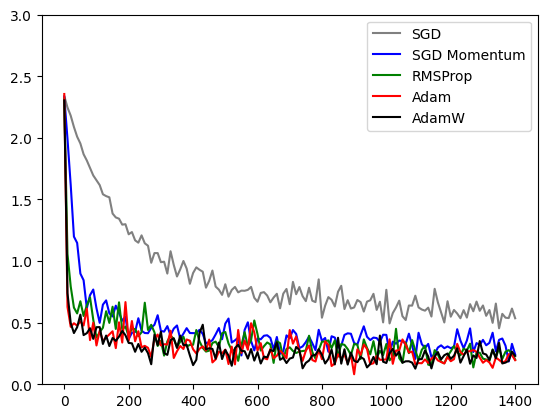

In [ ]:
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS)[::10],
    sgd_loss_info.full_train_losses[::10],
    label="SGD",
    c="grey",
)
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS)[::10],
    sgd_momentum_loss_info.full_train_losses[::10],
    label="SGD Momentum",
    c="blue",
)
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS)[::10],
    rmsprop_loss_info.full_train_losses[::10],
    label="RMSProp",
    c="green",
)
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS)[::10],
    adam_loss_info.full_train_losses[::10],
    label="Adam",
    c="red",
)
plt.plot(
    np.arange(len(train_dataloader) * EPOCHS)[::10],
    adamw_loss_info.full_train_losses[::10],
    label="AdamW",
    c="black",
)

plt.ylim(0, 3)

plt.legend()
plt.show()